# Deep Learning with PyTorch for Loan Approval Prediction

In this notebook, we'll focus on implementing a deep learning solution using PyTorch for our loan approval prediction task. We'll build upon the preprocessing done in TP01 (Pandas) and TP02 (Scikit-learn).

## Steps we'll cover:

1. Introduction to PyTorch tensors and neural network basics
2. Building a neural network model
3. Training process and optimization
4. Model evaluation and visualization
5. Comparing with previous models

Let's start by understanding PyTorch basics and how it differs from traditional machine learning approaches.


# 1. Introduction to PyTorch Tensors

PyTorch is a popular deep learning framework that provides:
- A powerful N-dimensional tensor object
- Automatic differentiation for building neural networks
- GPU acceleration for fast computation

Let's start by understanding how PyTorch tensors work and how they differ from NumPy arrays.


In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create different types of tensors
# 1. From Python list
tensor_from_list = torch.tensor([1, 2, 3, 4, 5])
print("Tensor from list:", tensor_from_list)

# 2. From NumPy array
numpy_array = np.array([1, 2, 3, 4, 5])
tensor_from_numpy = torch.from_numpy(numpy_array)
print("\nTensor from NumPy:", tensor_from_numpy)

# 3. Random tensor
random_tensor = torch.rand(3, 3)
print("\nRandom tensor:\n", random_tensor)

# 4. Tensor operations
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
print("\nAddition:", a + b)
print("Multiplication:", a * b)

# 5. Tensor with gradients
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = x * 2
z = y.mean()
z.backward()  # Compute gradients
print("\nGradients:", x.grad)  # Shows dz/dx


Tensor from list: tensor([1, 2, 3, 4, 5])

Tensor from NumPy: tensor([1, 2, 3, 4, 5])

Random tensor:
 tensor([[0.3130, 0.3548, 0.9303],
        [0.9851, 0.4685, 0.5454],
        [0.2129, 0.7359, 0.3756]])

Addition: tensor([5, 7, 9])
Multiplication: tensor([ 4, 10, 18])

Gradients: tensor([0.6667, 0.6667, 0.6667])


# 2. Loading Pre-processed Data

We'll use the pre-processed data from TP02. The data has already been:
- Cleaned and formatted (TP01)
- Encoded and scaled (TP02)

Now we'll load this data and convert it into PyTorch tensors for our neural network.


In [6]:
# Load the pre-processed data
df_scaled = pd.read_csv('loan_approval_scaled.csv')

# Prepare features and target
X = df_scaled.drop('loan_status', axis=1)
y = df_scaled['loan_status']

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.FloatTensor(y.values)

print("Feature tensor shape:", X_tensor.shape)
print("Target tensor shape:", y_tensor.shape)

# Create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

print("\nTraining set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Feature tensor shape: torch.Size([4269, 12])
Target tensor shape: torch.Size([4269])

Training set size: torch.Size([3415, 12])
Testing set size: torch.Size([854, 12])


# 3. Building Neural Network Model

Now we'll create a neural network using PyTorch's `nn.Module`. The key components are:
- Input layer (matching our feature dimensions)
- Hidden layers with non-linear activation functions
- Output layer with sigmoid activation for binary classification
- Dropout layers for regularization

Let's implement this step by step.


In [7]:
import torch.nn as nn

class LoanApprovalNet(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNet, self).__init__()
        
        # First hidden layer
        self.hidden1 = nn.Linear(input_size, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second hidden layer
        self.hidden2 = nn.Linear(64, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # First hidden layer
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.hidden2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Output layer
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

# Create model instance
input_size = X_train.shape[1]
model = LoanApprovalNet(input_size)
print(model)


LoanApprovalNet(
  (hidden1): Linear(in_features=12, out_features=64, bias=True)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


# 4. Training Process

The training process in PyTorch involves:
1. Forward pass: Making predictions
2. Computing loss: Measuring prediction error
3. Backward pass: Computing gradients
4. Optimization step: Updating weights

We'll also implement:
- Learning rate scheduling
- Early stopping
- Training progress visualization


In [9]:
# Create data loaders
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
patience_counter = 0

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y.view(-1, 1)).item()
    
    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Starting training...
Epoch [10/100]
Train Loss: 0.6596, Val Loss: 0.6610
Epoch [20/100]
Train Loss: 0.6331, Val Loss: 0.6282
Early stopping at epoch 26


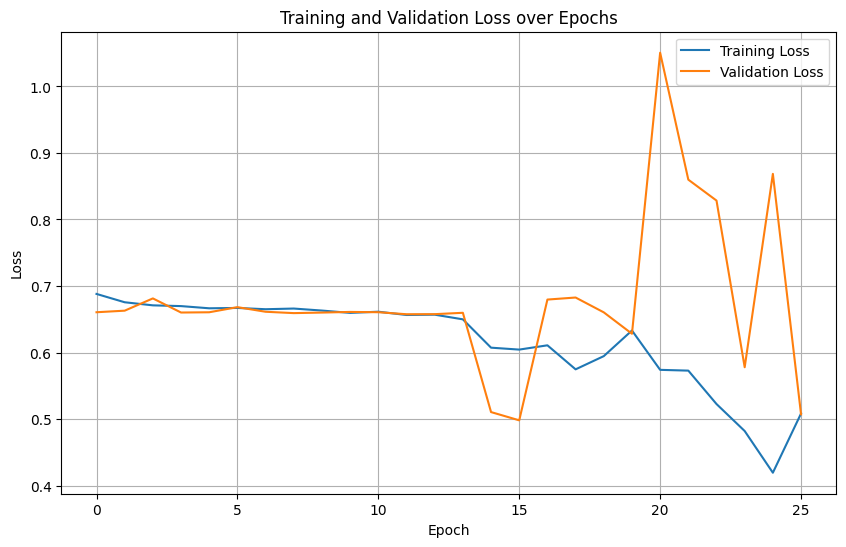


Test Accuracy: 0.7354

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.44      0.55       318
         1.0       0.73      0.91      0.81       536

    accuracy                           0.74       854
   macro avg       0.74      0.68      0.68       854
weighted avg       0.74      0.74      0.72       854


Confusion Matrix:
[[140 178]
 [ 48 488]]


In [10]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred >= 0.5).float().view(-1)
    
    # Calculate accuracy
    accuracy = (y_pred_class == y_test).float().mean()
    print(f'\nTest Accuracy: {accuracy.item():.4f}')
    
    # Additional metrics
    from sklearn.metrics import classification_report, confusion_matrix
    print('\nClassification Report:')
    print(classification_report(y_test.numpy(), y_pred_class.numpy()))
    
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test.numpy(), y_pred_class.numpy()))


# 5. Advanced PyTorch Features

Now let's explore some advanced PyTorch features that make it powerful for deep learning:
1. Model interpretability
2. Feature importance visualization
3. Saving and loading models


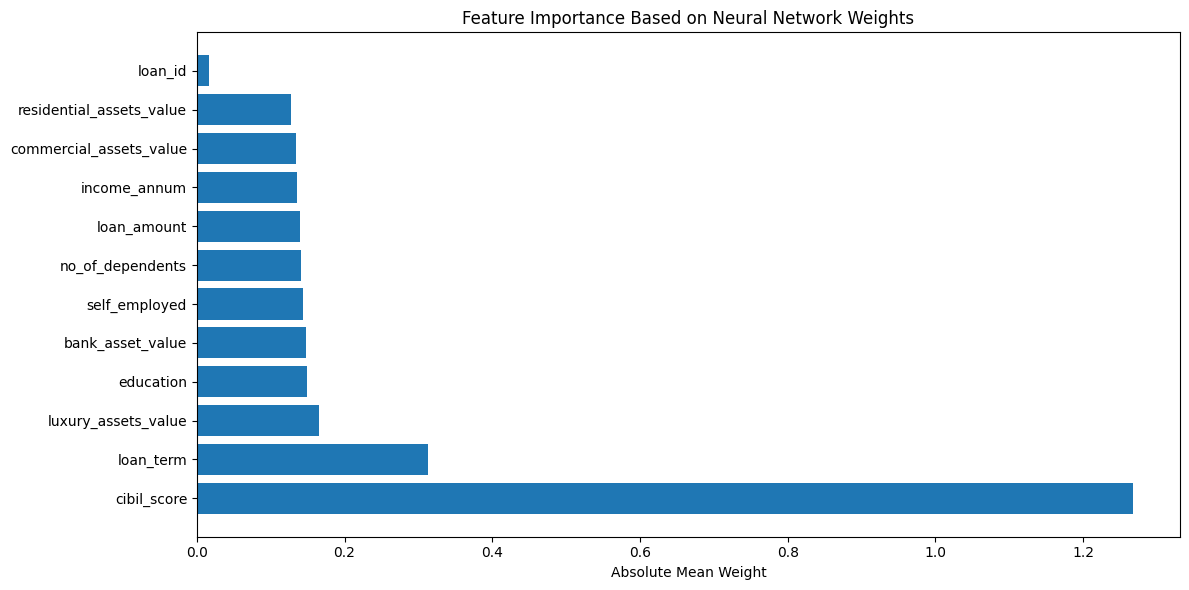


Feature Importance Ranking:
cibil_score: 1.2679
loan_term: 0.3127
luxury_assets_value: 0.1656
education: 0.1491
bank_asset_value: 0.1480
self_employed: 0.1442
no_of_dependents: 0.1407
loan_amount: 0.1398
income_annum: 0.1354
commercial_assets_value: 0.1338
residential_assets_value: 0.1275
loan_id: 0.0166


In [12]:
# Feature importance based on first layer weights
def get_feature_importance(model, feature_names):
    # Get the weights from the first layer
    weights = model.hidden1.weight.data
    
    # Calculate the absolute mean of weights for each input feature
    importance = torch.abs(weights).mean(dim=0)
    
    return {name: imp.item() for name, imp in zip(feature_names, importance)}

# Get feature names from original dataset
feature_names = X.columns.tolist()

# Calculate feature importance
importance_dict = get_feature_importance(model, feature_names)

# Sort features by importance
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
features, importance = zip(*sorted_features)
plt.barh(features, importance)
plt.title('Feature Importance Based on Neural Network Weights')
plt.xlabel('Absolute Mean Weight')
plt.tight_layout()
plt.show()

# Print feature importance ranking
print("\nFeature Importance Ranking:")
for feature, imp in sorted_features:
    print(f"{feature}: {imp:.4f}")


In [13]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}, 'loan_approval_pytorch_model.pth')

print("Model saved successfully!")

# Example of how to load the model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = LoanApprovalNet(input_size)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Load the model (commented out as example)
# loaded_model = load_model('loan_approval_pytorch_model.pth')


Model saved successfully!
